We want to look for some aggregate facts about the US economy and its trade patterns to get a sense of how some macroeconomic indicators had evolved around China's WTO accession. In particular we will show that


* Expansion of Chinese Trade. Essentially all of US trade growth since the 1990s is from the expansion of Chinese imports.
* Fall in Real Interest Rates Around the time the Chinese trade expanded.
* Expansion of the Trade Deficit during this time period.

To do this we will access data from the FRED database.

Load the packages:

In [1]:
import pandas as pd
from pandas_datareader import data #, wb # This will import the data reader
import numpy as np
import matplotlib.pyplot as plt

## Get FRED Data

For this notebook we will want data on nominal GDP, total imports, total exports imports from China, the 1-Year Treasury Constant Maturity Rate and the CPI index computed without energy and food.

Go to the FRED data site: https://fred.stlouisfed.org/ and find out the codes / variable names you need to access from the API. 

Store the variables names in a list called `code`

If you are too lazy to do this (you shouldn't be!), I have them in [this document](https://github.com/pp4rs/2020-uzh-course-material/blob/master/10-python-project/instructor/fred_codes.txt)

In [2]:
codes = ["GDP", "IMPGS", "EXPGS", "IMPCH", "GS1", "CPILFESL"] 
# nomial gdp, imports, imports from china, constant maturity 1 year rate, cip (no energy or food)

Import the data ffrom FRED using the pandas_datareader API from 1990 until present

In [3]:
fred = data.DataReader(codes,"fred",1990)  # Then for fred, you hand it the codes
                                            # Tell it you want to ask from FRED
                                            # then tell it the start date

Inspect the head and tail of this data

In [4]:
fred.head()

,GDP,IMPGS,EXPGS,IMPCH,GS1,CPILFESL
DATE,,,,,,
1990-01-01,5872.701,626.767,538.232,1186.1,7.92,132.1
1990-02-01,NaN,NaN,NaN,993.8,8.11,132.7
1990-03-01,NaN,NaN,NaN,931.0,8.35,133.5
1990-04-01,5960.028,614.759,545.925,996.4,8.40,134.0
1990-05-01,NaN,NaN,NaN,1173.5,8.32,134.4


In [5]:
fred.tail()

,GDP,IMPGS,EXPGS,IMPCH,GS1,CPILFESL
DATE,,,,,,
2019-09-01,NaN,NaN,NaN,40220.142151,1.80,264.595
2019-10-01,21734.266,3073.977,2495.59,40145.706389,1.61,265.011
2019-11-01,NaN,NaN,NaN,36468.921978,1.57,265.620
2019-12-01,NaN,NaN,NaN,NaN,1.55,265.921
2020-01-01,NaN,NaN,NaN,NaN,1.53,NaN


What do you notice about the frequency of the different series?

## Fact 1: Expansion of Chinese Trade to the US

Here we will construct graphical evidence that the growth in Chinese Imports Accounts for Aggregate Import Growth since China joined the WTO in 2002.
This is equivalent to saying non chinese imports are not increasing over time. 

To make the comparison, we will do everything relative to GDP - i.e. we will want to show the chinese imports as a fraction of GDP are increasing since WTO accession, while non-chinese imports as a fraction of GDP are not.

Based on what we saw above, the frequency of chinese import data and all imports of goods and services are different. Thus, as a first step - we need to aggreagate the monthly Chinese import data to a quarterly level.

Let's proceed as follows:

First, create a dataset `china_imports` that only selects the chinese import data from the fred data:

In [6]:
china_imports = pd.DataFrame(fred["IMPCH"])

In [7]:
china_imports.head()

,IMPCH
DATE,
1990-01-01,1186.1
1990-02-01,993.8
1990-03-01,931.0
1990-04-01,996.4
1990-05-01,1173.5


In class we didn't discuss techniques to aggregate data to a higher level.

The command we need is `resample`. Look at the help for this function `help(pd.DataFrame.resample)`, and use what you learn to aggregate the monthly data to a quarterly series using `convention = 'end'` option to create a dataset `china_imports_q`. Also, rename the column to `ch_imports`:

In [8]:
china_imports = pd.DataFrame(fred["IMPCH"].resample("Q", convention= 'end').sum())

In [9]:
china_imports_q = china_imports.resample("Q", convention = 'end').sum()

In [10]:
china_imports_q.rename(columns = {"IMPCH": "ch_imports"}, inplace = True)

In [11]:
china_imports_q.head()

,ch_imports
DATE,
1990-03-31,3110.9
1990-06-30,3487.1
1990-09-30,4493.2
1990-12-31,4146.2
1991-03-31,3549.6


In [12]:
china_imports_q.tail()

,ch_imports
DATE,
2019-03-31,105973.901790
2019-06-30,113070.361766
2019-09-30,122916.157549
2019-12-31,76614.628367
2020-03-31,0.000000


Notice how the `DATE` index uses the last day of quarter? This will not align with the quarterly data in the rest of our FRED data columns. What we need to is push the `DATE` forward by one day.

Look at the help in the function `pd.DateOffset`, and push the date index forward by one day:

In [13]:
china_imports_q.index = china_imports_q.index + pd.DateOffset(days=1)

In [14]:
china_imports_q.head()

,ch_imports
DATE,
1990-04-01,3110.9
1990-07-01,3487.1
1990-10-01,4493.2
1991-01-01,4146.2
1991-04-01,3549.6


Now we want to create a dataset with chinese trade as a fraction of gdp and total imports as a percentage of gdp.

Merge the chinese import data with only the GDP and IMPGS data from fred to create a data set called `trade_data`

In [15]:
trade_data = pd.merge(china_imports_q,
                      fred[['IMPGS','GDP']],
                      left_index = True, 
                      right_index = True,
                      how = 'inner'
                     )

In [16]:
trade_data.head()

,ch_imports,IMPGS,GDP
DATE,,,
1990-04-01,3110.9,614.759,5960.028
1990-07-01,3487.1,630.102,6015.116
1990-10-01,4493.2,647.282,6004.733
1991-01-01,4146.2,620.317,6035.178
1991-04-01,3549.6,613.921,6126.862


If we inspect `trade_data`, we see that ch_imports is a *much* larger number than `IMPGS` - suggesting they must be measured in different quantities.

In fact chinese imports are measured in millons of USD, but total imports are measured in billions (as is GDP). Verify this by looking at variable definitions on the fred website, https://fred.stlouisfed.org/ .

Adjust `ch_imports` so that it is measured in billions of dollars:

In [17]:
trade_data["ch_imports"] = 0.01*trade_data["ch_imports"] 

In [18]:
trade_data.head()

,ch_imports,IMPGS,GDP
DATE,,,
1990-04-01,31.109,614.759,5960.028
1990-07-01,34.871,630.102,6015.116
1990-10-01,44.932,647.282,6004.733
1991-01-01,41.462,620.317,6035.178
1991-04-01,35.496,613.921,6126.862


In [19]:
trade_data.tail()

,ch_imports,IMPGS,GDP
DATE,,,
2019-01-01,1446.752910,3154.126,21098.827
2019-04-01,1059.739018,3166.691,21340.267
2019-07-01,1130.703618,3148.168,21542.540
2019-10-01,1229.161575,3073.977,21734.266
2020-01-01,766.146284,NaN,NaN


Now resample the data to be annual, and:

* compute chinese import share of gdp, `china_share`
* compute the nonchinese import share of gdp, `nonchina_share`
* drop the row IMPGS
* rename GDP to gdp

In [20]:
trade_data = trade_data.resample("Y", convention= 'end').sum()

In [21]:
trade_data['china_share'] = 100 * trade_data.ch_imports / trade_data.GDP
trade_data['global_share'] = 100 * trade_data.IMPGS / trade_data.GDP
trade_data['nonchina_share'] = 100 * (trade_data.IMPGS - trade_data.ch_imports) / trade_data.GDP

In [22]:
trade_data.head()

,ch_imports,IMPGS,GDP,china_share,global_share,nonchina_share
DATE,,,,,,
1990-12-31,110.912,1892.143,17979.877,0.616867,10.523670,9.906803
1991-12-31,173.282,2494.177,24632.517,0.703469,10.125547,9.422078
1992-12-31,244.233,2671.163,26081.309,0.936429,10.241675,9.305246
1993-12-31,301.245,2879.891,27434.234,1.098062,10.497435,9.399373
1994-12-31,368.316,3253.697,29148.946,1.263565,11.162314,9.898749


In [23]:
#trade_data.drop(columns=['GDP', 'IMPGS'], inplace=True)

Plot `china_share` and `nonchina_share` over time as a line plot from 1991 to the beginning of 2008. Add a vertical line at the beginning of 2002 to mark the accession of China into the WTO:

/home/lachlan/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


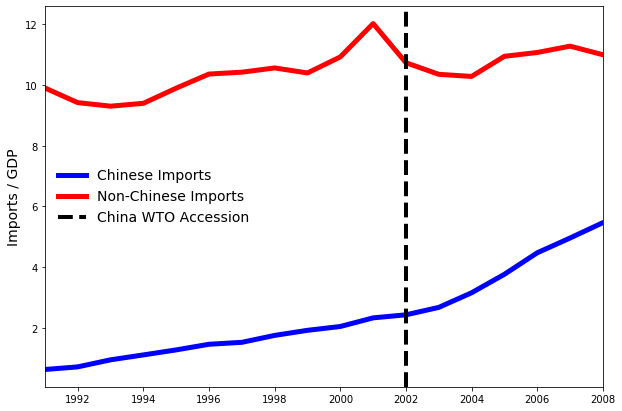

In [24]:
fig, ax = plt.subplots(figsize = (10,7))


ax.plot(trade_data["china_share"], color = "blue",
        linewidth = 5, label = "Chinese Imports")

ax.plot(trade_data["nonchina_share"], color = "red",
        linewidth = 5, label = "Non-Chinese Imports")

ax.set_ylabel("Imports / GDP", fontsize = 14)

ax.set_xlim("1991-01-01", "2008-01-01")

ax.axvline(x= "2002-01-01",           # Set the value equall to the average
           color='k',       # make the color red
           label='China WTO Accession', # this is the label (shows up in the legend)
           linestyle='--',   # the line style
           linewidth=4)     # thickness of the line

ax.legend(loc="best", fontsize = 14, frameon=False)


## Fact 2: 400 basis point fall in real Interest rates leading into China Expansion

Extract the interest rate `GS1` from the fred data and resample at the quarterly interval - call the data `irates`.
Do the same for the CPI `CPILFESL`, calling the data `inflation`.

Compute the annualized change in the real interest rate (HINT: what option can you pass to `pct_change`?).

In [25]:
irates = pd.DataFrame(fred["GS1"].resample("Q", convention= 'end').mean())

irates.index = irates.index + pd.DateOffset(days=1)

inflation = pd.DataFrame(fred["CPILFESL"].resample("Q", convention= 'end').mean())

inflation.index = inflation.index + pd.DateOffset(days=1)

irates["real"] = irates["GS1"] - 100*inflation["CPILFESL"].pct_change(4)

In [26]:
inflation["CPILFESL"].pct_change(4)

DATE
1990-04-01         NaN
1990-07-01         NaN
1990-10-01         NaN
1991-01-01         NaN
1991-04-01    0.054984
                ...   
2019-04-01    0.020912
2019-07-01    0.020654
2019-10-01    0.023177
2020-01-01    0.022939
2020-04-01    0.017225
Freq: QS-OCT, Name: CPILFESL, Length: 121, dtype: float64

In [26]:
irates.head()

,GS1,real
DATE,,
1990-04-01,8.126667,NaN
1990-07-01,8.273333,NaN
1990-10-01,7.826667,NaN
1991-01-01,7.303333,NaN
1991-04-01,6.436667,0.938299


Construct a line plot that shows immediately prior to the Chinese WTO accession US real interest rates fell by approx. 400 basis points:

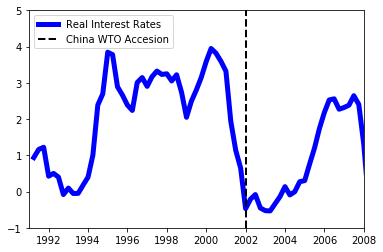

In [27]:
fig, ax = plt.subplots()

ax.plot(irates.real, color = "blue", lw = 5,
        label = "Real Interest Rates")

ax.set_xlim("1991-01-01", "2008-01-01")
ax.set_ylim(-1, 5)

ax.axvline(x= "2002-01-01",           # Set the value equall to the average
           color='k',       # make the color red
           label='China WTO Accesion', # this is the label (shows up in the legend)
           linestyle='--',   # the line style
           linewidth=2)     # thickness of the line

plt.legend()



## Fact 3: Expanding Trade Deficit

The US trade deficit, i.e exports minus imports, worsened after the chinese WTO accession.

Compute the trade deficit as a percentage of GDP, and plot it from 1991 until the beginning of 2008. Again, add a line to show that after China entered the WTO the deficit got much worse.

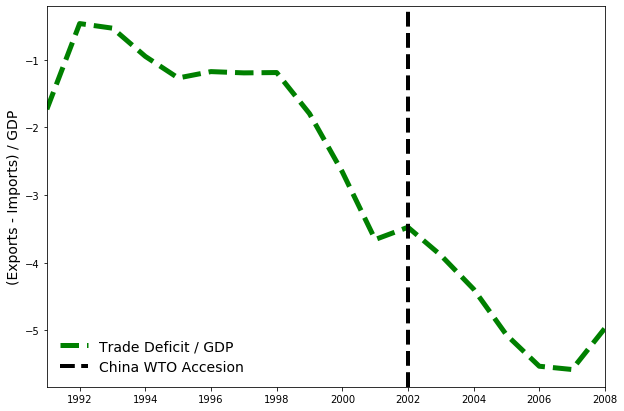

In [28]:
trade_data["trade_deficit"] = (fred["EXPGS"] - fred["IMPGS"]).resample("Y", convention= 'end').sum()

trade_data["trade_deficit"] = 100 * trade_data["trade_deficit"]/trade_data["GDP"]

fig, ax = plt.subplots(figsize = (10,7))

ax.plot(trade_data.trade_deficit, color = "green", lw = 5,
        label = "Trade Deficit / GDP", ls = "--")

ax.set_xlim("1991-01-01", "2008-01-01")
#ax.set_ylim(-6, 0)

ax.set_ylabel("(Exports - Imports) / GDP", fontsize = 14) 

ax.axvline(x= "2002-01-01",           # Set the value equall to the average
           color='k',       # make the color red
           label='China WTO Accesion', # this is the label (shows up in the legend)
           linestyle='--',   # the line style
           linewidth=4)     # thickness of the line

ax.legend(loc="lower left", fontsize = 14, frameon=False)
